<div style="text-align: center;"> 

# Bagging and Boosting (with trees)

## Amanda Kube Jotte - University of Chicago
## Data 22100

<img
  src="https://raw.githubusercontent.com/amandakube/Data118LectureImages/main/UChicago_DSI.png"
  alt="UC-DSI"
  style="display:block; margin: 1em auto;"
  width="500"
  height="600">
    
</div>


## Bagging - a Random Forest

### A decision tree is prone to overfitting, so why settle for a single tree? 

|   |   |
|:--|:--|
| <img src="https://github.com/david-biron/DATA221imgs/blob/main/icon_definition.png?raw=true" width="50" height=""> | **Ensemble methods** aggregate the result from a set of classifiers (or regression <br> models).  Individual predictions of 'weak learners' are aggregated by the <br> majority rule (or averaging) to identify the most popular result. |

|   |   |
|:--|:--|
| <img src="https://github.com/david-biron/DATA221imgs/blob/main/icon_definition.png?raw=true" width="50" height=""> | **Bagging (or bootstrap aggregation)** is an ensemble learning method: <br> a random sample of data in a training set is selected **with replacement**. Several <br> data samples are generated, used to train models independently, and the  result <br> is aggregated by a majority  rule (classification) or averaging (regression). <br> Typically, bagging reduces variance. |

|   |   |
|:--|:--|
| <img src="https://github.com/david-biron/DATA221imgs/blob/main/icon_definition.png?raw=true" width="50" height=""> | **Feature randomness (or 'feature bagging')** generates random subsets of features. <br>  This reduces the correlations between the resulting classifiers (or regression models). |

|   |   |
|:--|:--|
| <img src="https://github.com/david-biron/DATA221imgs/blob/main/icon_definition.png?raw=true" width="50" height=""> | A **random forest** combines bagging and feature randomness to create multiple lowly <br> correlated decision trees. Each individual tree is a weak learner. The forest aggregates <br> their results (majority rule or average) to identify the most popular result. <br> Typically, this reduces the risk of overfitting and increases the accuracy of predictions.  |


In [13]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

##############################
# Rudimentary Data Wrangling #
#    (crude, but will do)    #
##############################

# Read ethnicity data file 
ethn_df = pd.read_csv('../Data/Brexit-Constituency-Ethnicity.csv')

# Rename the constituency column (for later join) 
ethn_df.rename({'ConstituencyName': 'Constituency'}, axis=1, 
               inplace=True)

# Sort alphabetically by constituency
ethn_df.sort_values(by='Constituency', axis=0, ascending=True, 
                    inplace=True, ignore_index=True)

# Correct wrong character
ethn_df.loc[647, 'Constituency'] = 'Ynys Mon' 

# Correct name (extra 'South' moved)
ethn_df.loc[117, 'Constituency'] = \
    'Carmarthen West and South Pembrokeshire' 

# Read constituency data file 
data_df = pd.read_csv('../Data/Brexit-UK-constituency-data.csv')

# Rename the constituency column (for later join)
data_df.rename({'PCON14NM': 'Constituency'}, axis=1, inplace=True)

# Remove 'England', 'Northern Ireland', 'Scotland', 'UK', 'Wales'
# from constituencies
data_df = data_df[~data_df['Constituency'].isin(\
        ['England', 'Northern Ireland', 'Scotland', 'UK', 'Wales'])]

# Sort alphabetically by constituency
data_df.sort_values(by='Constituency', axis=0, ascending=True, 
                    inplace=True, ignore_index=True)

# Correct wrong character
data_df.loc[647, 'Constituency'] = 'Ynys Mon' 

# Read results (votes) data file 
rslt_df = pd.read_csv('../Data/Brexit-results.csv')

# Sort alphabetically by constituency
rslt_df.sort_values(by='Constituency', axis=0, ascending=True, 
                    inplace=True, ignore_index=True)

# Make sure that constituencies in ethn_df match those in rslt_df
# and that constituencies in data_df match those in rslt_df
for k in range(len(rslt_df)): 
    if (rslt_df.Constituency[k] in ethn_df.Constituency[k]) or \
       (ethn_df.Constituency[k] in rslt_df.Constituency[k]): 
        ethn_df.loc[k, 'Constituency'] = rslt_df.Constituency.values[k]
    if (rslt_df.Constituency[k] in data_df.Constituency[k]) or \
       (data_df.Constituency[k] in rslt_df.Constituency[k]): 
        data_df.loc[k, 'Constituency'] = rslt_df.Constituency.values[k]

#for c in set(data_df.Constituency) - set(rslt_df.Constituency): 
#    idxs = [i for i in rslt_df.Constituency.index if \
#            c in rslt_df.Constituency[i]]
#    jdxs = [j for j in data_df.Constituency.index if \
#            c in data_df.Constituency[j]]
#    if len(idxs)==1 and len(jdxs)==1:
#        data_df.loc[jdxs[0], 'Constituency'] = \
#                   rslt_df.Constituency.values[idxs[0]]

# Check that data_df, rslt_df, and ethn_df have the same lengths
print('Length of dataframes: ', len(rslt_df), 
                                len(data_df), len(ethn_df))

# Check the class balance between constituencies 'for' and 'against' 
print('Class Balance: %.1f%% for leaving and %.1f%% against.'%\
                      (100*sum(rslt_df.Leave>'50')/len(rslt_df), 
                       100*sum(rslt_df.Leave<'50')/len(rslt_df)))

# Check that data_df, rslt_df, and ethn_df have the same constituencies
print('Constituency name discrepencies:', 
      set(rslt_df.Constituency) - set(data_df.Constituency), 
      set(data_df.Constituency) - set(rslt_df.Constituency), 
      set(rslt_df.Constituency) - set(ethn_df.Constituency),  
      set(ethn_df.Constituency) - set(rslt_df.Constituency) )


Length of dataframes:  650 650 650
Class Balance: 62.9% for leaving and 37.1% against.
Constituency name discrepencies: set() set() set() set()


In [14]:
###########################################
# Determine predictor and outcome columns #
#    (and fill in some missing values)    #
###########################################

# Creat a 'Brexit' column: 
#    1 for leaving the EU ('yes' to Brexit)
#    0 for staying in the EU ('no' to Brexit)
rslt_df['Brexit'] = (rslt_df.Leave>'50').astype(int)  
                                                     
rslt_df.head(20) 
df = rslt_df
df = df.merge(data_df, how='inner')
df = df.merge(ethn_df, how='inner')

outcome = 'Brexit'
predictors = [
       'salary', 'publicsector', 'degree', 'age', 'nonukborn', 
       'health', 'PopTotalConstNum', 'PopWhiteConst%', 
       'PopMixedConst%', 'PopAsianConst%', 'PopBlackConst%', 
       'PopWhiteReg%',   'PopMixedReg%',   'PopAsianReg%',   
       'PopBlackReg%'
    ] 

# Convert 'x' (code for missing values) to np.nan
print("Missing values in public sector column (no. of 'x's):", 
                                    len(df[df.publicsector=='x']))
df.loc[df.publicsector=='x','publicsector'] = np.nan

# Convert all predictors types to float 
df[predictors] = df[predictors].astype(float)

# Replace missing values with the mean value: 
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
vals2d = df.publicsector.values.reshape(-1, 1)
imp.fit(vals2d) # the imputer fitting function needs a 2d array 
df.publicsector = imp.transform(vals2d).reshape(-1) # pandas need a 
                                                    # 1d array 
print('\nAfter imputing...')    
print("Missing values in public sector column (no. of NaNs):", 
                                            df.isnull().sum().sum())


Missing values in public sector column (no. of 'x's): 18

After imputing...
Missing values in public sector column (no. of NaNs): 0


In [15]:
brexit_df = df.copy()
brexit_df

,Constituency,Leave,Remain,Brexit,PCON14CD,house,salary,publicsector,degree,age,...,PopMixedUKNum,PopAsianUKNum,PopBlackUKNum,PopOtherUKNum,PopTotalUK%,PopWhiteUK%,PopMixedUK%,PopAsianUK%,PopBlackUK%,PopOtherUK%
0,Aberavon,60.12%,39.88%(est.),1,W07000049,95000,490.3,25.2,16.6,39.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
1,Aberconwy,52.20%,47.8%(est.),1,W07000058,155000,496.3,23.4,27.1,39.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
2,Aberdeen North,43.09%,56.91%(est.),0,S14000001,x,538.3,37.0,29.0,41.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
3,Aberdeen South,32.14%,67.86%(est.),0,S14000002,x,584.1,9.2,40.3,40.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
4,Airdrie and Shotts,39.84%,60.16%(est.),0,S14000003,x,482.3,26.2,15.5,46.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,Wythenshawe and Sale East,49.65%,50.35%(est.),0,E14001059,142000,437.2,17.5,24.8,34.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
646,Yeovil,59.87%,40.13%(est.),1,E14001060,165000,472.2,17.5,23.0,31.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
647,Ynys Mon,50.94%,49.06%,1,W07000041,142750,444.8,24.7,26.1,41.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
648,York Central,38.82%,61.18%(est.),0,E14001061,167000,461.1,26.5,32.7,41.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186


In [16]:
from sklearn.model_selection import train_test_split

###############################################
# Split data to training and testing datasets #
###############################################
X_train, X_test, y_train, y_test = \
    train_test_split(brexit_df[predictors], 
                     brexit_df[outcome], 
                     test_size=0.3) 



In [17]:
from sklearn.ensemble import RandomForestClassifier as rnd_frst
from sklearn.model_selection import cross_val_score, \
                                    LeaveOneOut, RepeatedKFold
from sklearn.metrics import mean_squared_error, roc_curve, auc, \
                            f1_score    

#############################################
# Cross validate to get evaluation metrics  #
#############################################

model = rnd_frst(max_depth=5) # smaller trees 
k_folds = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_train, y_train, 
                     scoring='f1',
                     cv=k_folds, n_jobs=None)
print('Mean F1 score=%.2f'%np.abs(scores).mean())


##########################################
# Train the model / fit model parameters #
#       and test on testing dataset      #
##########################################

model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_hat = model.predict(X_test)
print('F1 score for the *training* dataset = %.3f'%\
      f1_score(y_train, y_train_hat))
print('F1 score for the *testing* dataset = %.3f'%\
      f1_score(y_test, y_hat))



Mean F1 score=0.93
F1 score for the *training* dataset = 0.958
F1 score for the *testing* dataset = 0.902


### Feature importances are averaged across the trees in the forest:

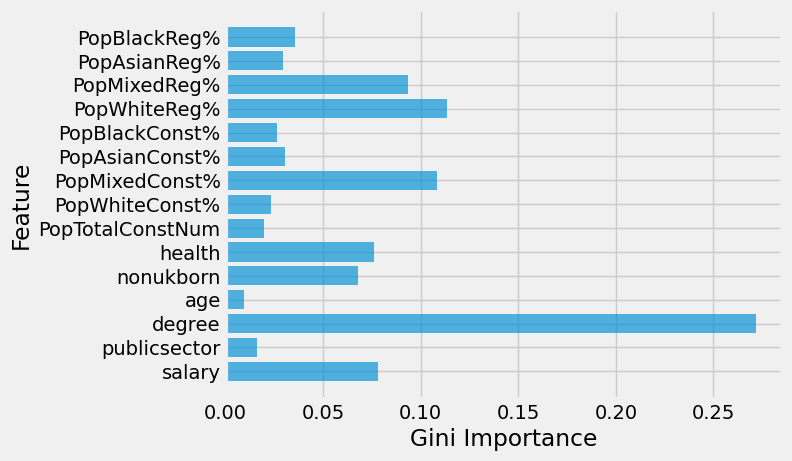

In [18]:
plt.barh(predictors, model.feature_importances_, alpha=0.67)
plt.xlabel("Gini Importance")
plt.ylabel("Feature");


### Hyperparameters of a random forest and how to search for them (`RandomizedSearchCV`)

* The **number of trees** (`n_estimators`): more trees may well improve performance but will require more time/memory for training. 

* The **maximum depth** of each decision tree (`max_depth`): excessively high (/low) values $\rightarrow$ overfitting (/underfitting).

* The **number of features** to consider when looking for the best split (`max_features`). 

[There are others...](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)


In [19]:
%%time

from sklearn.model_selection import RandomizedSearchCV
# In contrast to GridSearchCV, not all parameter values are 
# tried out. Rather, a fixed number of parameter settings is 
# sampled from the specified distributions. The number of 
# parameter settings that are tried is given by n_iter. 
#
# There are additional Hyper-parameter optimizers in 
# sklearn.model_selection

# Create a random forest classifier and a  
# dictionary of parameters to tweak
rf = rnd_frst()
param_dist = {'n_estimators': np.random.randint(50,500,4),
              'max_depth': np.random.randint(1,20,5)}

# Use random search to find the 'best' hyperparameters:

# create random search object
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist, 
                                 n_iter=10, 
                                 cv=5) 

# Fit the random search object to the data
rand_search.fit(X_train, y_train)


CPU times: user 12 s, sys: 101 ms, total: 12.1 s
Wall time: 11.8 s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([16, 15, 17, 12,  6]),
                                        'n_estimators': array([348,  79, 353, 424])})

In [20]:
# Create an instance of the best model
best_rf = rand_search.best_estimator_ 

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'n_estimators': 353, 'max_depth': 17}


F1 score for the *training* dataset = 1.000
F1 score for the *testing* dataset = 0.905




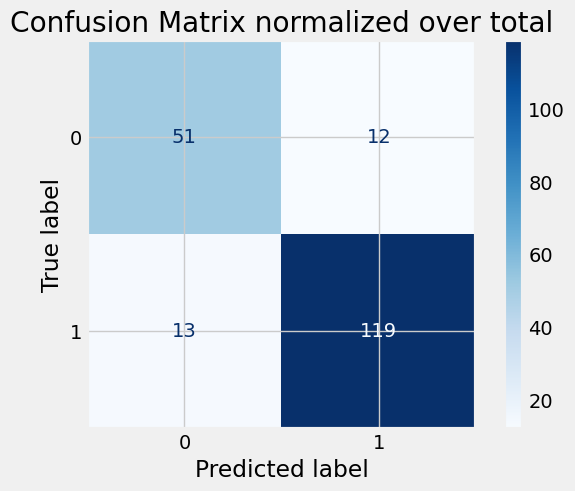

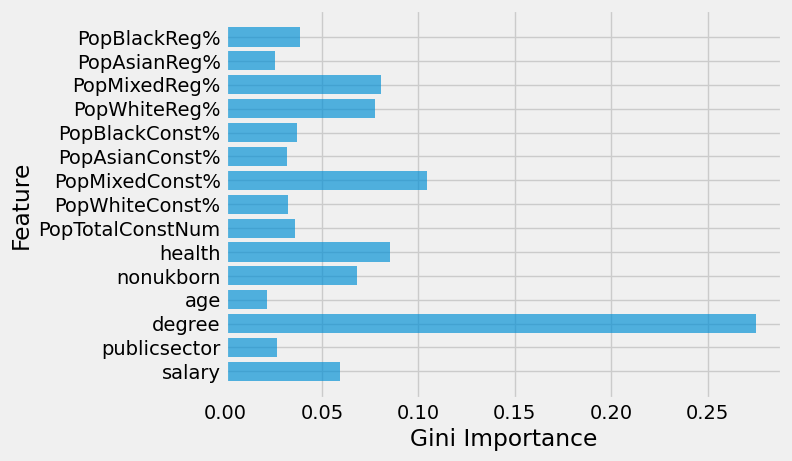

In [21]:
from sklearn.metrics import confusion_matrix, \
                            ConfusionMatrixDisplay 
from sklearn.metrics import f1_score, precision_score, \
                            recall_score, accuracy_score    

# Generate predictions with the best model
y_hat = best_rf.predict(X_test)
y_train_hat = best_rf.predict(X_train)
print('F1 score for the *training* dataset = %.3f'%\
      f1_score(y_train, y_train_hat))
print('F1 score for the *testing* dataset = %.3f\n\n'%\
      f1_score(y_test, y_hat))

# Create and display the confusion matrix
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay.from_predictions(
     y_test,
     y_hat, 
     cmap=plt.cm.Blues,
     normalize='all' 
    )
disp.ax_.set_title('Confusion Matrix normalized over total')

# Also plot fearure importances 
plt.figure()
plt.barh(predictors, best_rf.feature_importances_, alpha=0.67)
plt.xlabel("Gini Importance")
plt.ylabel("Feature");


#### The best model found still overfits and predicts quite a few false positives. 

### Perhaps a simpler model with seemingly more relevant features...

Education is clearly an important feature - it stays in. 

One hypothesis might be that race is the main other factor. Since, the no. of registered white voters is a large majority (almost?) everywhere, perhaps the percentages of the non-white population and white registered voters would be sufficient for good predicitons. 

### At this stage, formulate and test more than one hypothesis

The idea is to come up with models that
 * Draw from domain knowledge (liteature, preliminary results, etc.)
 * Lead to sensible hypotheses (a mechanism, causation, etc.)

#### Note: 

A model in and of itself would generally not prove (or even seriously test) a hypothesis.

It can 
* Disprove a hypothesis. 
* Provide some supporting evidence. 
* Be the best tool at hand to make predictions.  

F1 score for the *training* dataset = 1.000
F1 score for the *testing* dataset = 0.924


CPU times: user 23.5 s, sys: 509 ms, total: 24 s
Wall time: 25.7 s


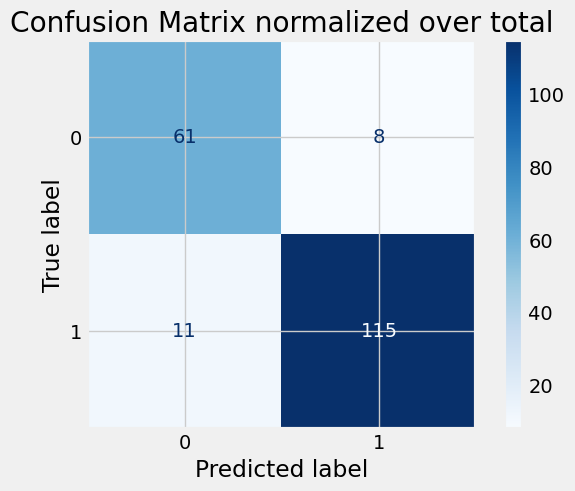

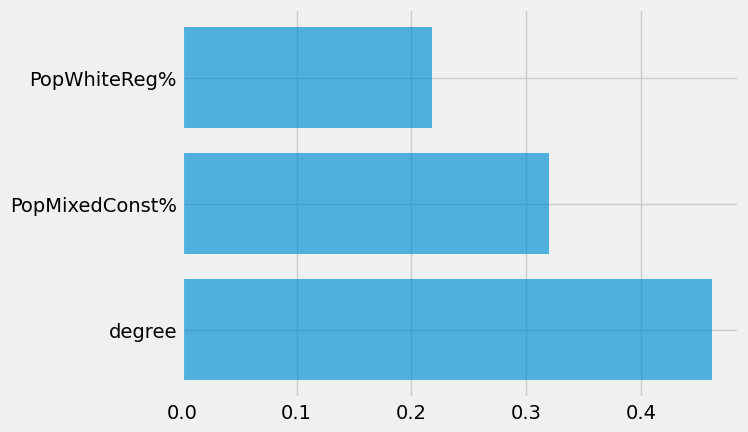

In [14]:
%%time 

predictors = ['degree', 'PopMixedConst%', 'PopWhiteReg%'] 
outcome = 'Brexit'

X_train, X_test, y_train, y_test = \
    train_test_split(brexit_df[predictors], 
                     brexit_df[outcome], 
                     test_size=0.3) 

rf = rnd_frst()
param_dist = {'n_estimators': np.random.randint(100,500,7),
              'max_depth': np.random.randint(10,25,7)}
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=20, 
                                 cv=5)
rand_search.fit(X_train, y_train)

best_rf = rand_search.best_estimator_ # This is our best forest!

y_hat = best_rf.predict(X_test)
y_train_hat = best_rf.predict(X_train)
print('F1 score for the *training* dataset = %.3f'%\
      f1_score(y_train, y_train_hat))
print('F1 score for the *testing* dataset = %.3f\n\n'%\
      f1_score(y_test, y_hat))

cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay.from_predictions(
     y_test,
     y_hat, 
     cmap=plt.cm.Blues,
     normalize=None # 'all' - Normalized by the total 
                    # number of samples 
    )
disp.ax_.set_title('Confusion Matrix normalized over total')

plt.figure()
plt.barh(predictors, best_rf.feature_importances_, alpha=0.67);



Performance did not improve much (sometimes it does not improve at all) but... 

<br/> 

#### This model seems to perform about as well as the model with all the features, and it is much easier to understand.  

### Pros and cons of random forests

**Pros** 
* Reduced risk of overfitting ('reduce variance'). 
* Can be used for classification or regression.
* Feature importance is simple to calculate.  

**Cons** 
* Time/memory consuming (the more trees...)
* Interpretability is lost as compared, e.g., to a single tree. 


## Boosting 

|   |   |
|:--|:--|
| <img src="http://github.com/david-biron/DATA221imgs/blob/main/icon_definition.png?raw=true" width="50" height=""> | **Boosting** combines weak learners (decision trees) **sequentially**. <br> The output of a weak learner are assigned **weights**. <br> The incorrect classifications of the current weak learner  <br> are given higher weights such that they have more <br> representations/influence as inputs to the next weak learner. |


#### Note

Boosting can be a powerful alternative to bagging. Instead of 'egalitarian' aggregation of predictions, boosters tweak weak learners by sequentially preferring to correct previous errors. 

In Gradient Boosting, an individual model is trained on the **residuals** of its predecessor, such that it learns from previous errors.

## AdaBoost

| AdaBoost | Random Forest | 
|:---------|:--------------|
| **Stumps**: one root and two leaves, i.e., depth=1 | Trees of arbitrary depth | 
| **Weighted votes** (on the final classification)   |  Majority rule           |
| **Stumps generated sequentially** and errors influence next stump | Trees generated independently | 

<img src="http://github.com/david-biron/DATA221imgs/blob/main/BaggingBoostingSketch.png?raw=true" width="525"> 

### An outline of the AdaBoost algorithm

* Each record in the training set is assigned a weight. These weights change every step <br/> and influence the representation of the corresponding records in the next step. <br/> Initially, all weights are equal so the training subset is randomly selected. 

<br/> 

* Select a training subset according to the weights.
* Train the current stump using the current training subset. 
* Assign higher weights to wrongly classified records. <br/> They will be more likely represented in the input for the next iteration.
* Assign an overall weight to the stump based on its accuracy (for instance). 
* Iterate until the training data fits without errors or the specified maximum number of stumps was reached.

<br/>

* Weighted-vote across all of the stumps using the overall weights assigned to each of them.


### How does AdaBoost take the previous stump's errors into account when generating the current one? 

### Consider the fictitious 'dataset' again: 

#### k = 0: all weights are equal 

|     |       |    |         | 
|:---:|:-----:|:--:|:-------:| 
| Age | sysBP | HD | Sample Weight | 
| 20  |  100  | 0  | 1/10    | 
| 30  |  130  | 0  | 1/10    | 
| 40  |  150  | 1  | 1/10    | 
| 45  |  140  | 1  | 1/10    | 
| 50  |  110  | 0  | 1/10    | 
| 60  |  140  | 1  | 1/10    | 
| 65  |  120  | 0  | 1/10    | 
| 70  |  110  | 0  | 1/10    | 
| 80  |  130  | 1  | 1/10    | 
| 90  |  120  | 1  | 1/10    | 


#### k = 1a: generate first stump (best split) and find its vote weight

* Split on `sysBP<125`: 

<img src="http://github.com/david-biron/DATA221imgs/blob/main/ExampleStumpKis1.png?raw=true" width="300"> 

$$\begin{eqnarray} 
Total\_Error &=& \sum_{\text{Errors}} \text{weights} = \frac 1{10} + \frac 1{10} = \frac 15 \\ Stump\_Vote\_Weight &=& \frac 12 \log \left[ \frac{1 - Total\_Error }{Total\_Error} \right] = \frac 12 \log 4 = \log 2 
\end{eqnarray}$$

[//]: # ($ Gini = \frac 12 \left[1 - \frac 45^2 - \frac 15^2 \right] + \frac 12 \left[ 1 - \frac 15^2 - \frac 45^2\right] = \frac 8{25}$)

**Note:** 

$\begin{eqnarray}
Total\_Error \to 0 \ \Rightarrow \ Stump\_Vote\_Weight \to \infty & \ &  \text{ (stump consistently correct)} \\  
Total\_Error = \frac 12 \ \Rightarrow \ Stump\_Vote\_Weight = 0 & \ & \text{ (stump is random)} \\ 
Total\_Error \to 1 \ \Rightarrow \ Stump\_Vote\_Weight \to -\infty & \ & \text{ (stump consistently incorrect)} 
\end{eqnarray}$ 

To avoid $\pm\infty$, a small error term is added (/subtracted) if the total error is $0$ (/$1$). 

<br>

#### k = 1b: update sample weights

Since the first stump mis-classified two samples, the updated sample weights will emphasize (overrepresent) them in the input for the second stump: 

$$\begin{eqnarray}
\text{Classification Error:} && New\_Sample\_Weight \\
&& = Old\_Sample\_Weight \times e^{Stump\_Vote\_Weight} \\
&& = \frac 1{10} \times e^{\log 2} = \frac 15 \\ 
\text{Correct Classification:} && New\_Sample\_Weight \\
&& = Old\_Sample\_Weight \times e^{{\Large {\color{red} -}}Stump\_Vote\_Weight} \\
&& = \frac 1{10} \times e^{{\Large {\color{red} -}}\log 2} = \frac 1{20} \\ 
&& \text{(normalize sum of weights to $1$ by dividing by the new sum)}
\end{eqnarray}$$

|     |       |    |         | 
|:---:|:-----:|:--:|:-------:| 
| Age | sysBP | HD | Sample Weight | 
| 20  |  100  | 0  | $1/20 \to 1/16$    | 
| 30  |  130  | 0  | $1/5 \to 4/16 $    | 
| 40  |  150  | 1  | $1/20 \to 1/16$    | 
| 45  |  140  | 1  | $1/20 \to 1/16$    | 
| 50  |  110  | 0  | $1/20 \to 1/16$    | 
| 60  |  140  | 1  | $1/20 \to 1/16$    | 
| 65  |  120  | 0  | $1/20 \to 1/16$    | 
| 70  |  110  | 0  | $1/20 \to 1/16$    | 
| 80  |  130  | 1  | $1/20 \to 1/16$    | 
| 90  |  120  | 1  | $1/5 \to 4/16 $    | 

**Note**: 

* The more succesful the stump, the more the sample weights of its errors are scaled up (emphasized). <br/> They are scaled down (de-emphasized) when the previous stump had a negative vote weight. 
* The more succesful the stump, the more the sample weights for correct classifications are scaled down (de-emphasized). <br/> They are scaled up (emphasized) when the previous stump had a negative vote weight.  

#### k = 2a: generate second stump (best split) and find its vote weight

There are two options: either find the next split with a **weighted Gini index** (using the sample weights):

$$ Weighted\_Gini = 1 - \sum_{\text{classes}} Class\_Weight \times Class\_Fraction^2 $$ 

OR 

Use the weights as a distribution to generate a dataset which is **the same size** as the original one but where the representation of each sample is proportional to its weight: 

* Generate a random number $0 \leq r \leq 1$. 
    * If $0 \leq r < 1/16$ pick $1^{st}$ sample. 
    * Elif $1/16 \leq r < 5/16$ pick $2^{nd}$ sample.    
    * Elif $5/16 \leq r < 6/16$ pick $3^{rd}$ sample.
    * Etc. 
* Repeat $N$ times where $N$ is the size of the original dataset. 
* Reset to equal sample weights. 

**Note**: 

Samples with higher weights will be picked more often (duplicated more). <br/> 
For not-too-small datasets, previous erroroneously classified samples will be represented more than previously correctly classified samples **in proportion to their weight ratio**. 

|     |       |    |         | 
|:---:|:-----:|:--:|:-------:| 
| Age | sysBP | HD | Sample Weight | 
| $20$          |  $100$  | $0$  | $1/10$    | 
| $\color{red}3\color{red}0$ |  $\color{red}1\color{red}3\color{red}0$  | $0$  | $1/10$    | 
| $40$          |  $150$  | $1$  | $1/10$    | 
| $\color{red}3\color{red}0$ |  $\color{red}1\color{red}3\color{red}0$  | $0$  | $1/10$    | 
| $50$          |  $110$  | $0$  | $1/10$    | 
| $\color{blue}9\color{blue}0$ |  $\color{blue}1\color{blue}2\color{blue}0$  | $1$  | $1/10$    | 
| $65$          |  $120$  | $0$  | $1/10$    | 
| $\color{red}3\color{red}0$ |  $\color{red}1\color{red}3\color{red}0$  | $0$  | $1/10$    | 
| $80$          |  $130$  | $1$  | $1/10$    | 
| $\color{blue}9\color{blue}0$ |  $\color{blue}1\color{blue}2\color{blue}0$  | $1$  | $1/10$    | 

This will be the input for the next stump! 

The repeated samples will either be correctly classified or mis-classified **as a block**. <br/> 
Therefore, their importance is now emphasized (in proportion to the previous weights ratio). 

### Finally, after generating a forest of stumps: 

To classify a given record:
* Sum the $Stump\_Vote\_Weight$s for the stumps that give $0$.
* Sum the $Stump\_Vote\_Weight$s for the stumps that give $1$. 
* The larger of the two sums determines the classification decision. 

### Implementing AdaBoost with `sklearn`

In [17]:
brexit_df.head()

,Constituency,Leave,Remain,Brexit,PCON14CD,house,salary,publicsector,degree,age,...,PopMixedUKNum,PopAsianUKNum,PopBlackUKNum,PopOtherUKNum,PopTotalUK%,PopWhiteUK%,PopMixedUK%,PopAsianUK%,PopBlackUK%,PopOtherUK%
0,Aberavon,60.12%,39.88%(est.),1,W07000049,95000,490.3,25.2,16.6,39.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
1,Aberconwy,52.20%,47.8%(est.),1,W07000058,155000,496.3,23.4,27.1,39.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
2,Aberdeen North,43.09%,56.91%(est.),0,S14000001,x,538.3,37.0,29.0,41.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
3,Aberdeen South,32.14%,67.86%(est.),0,S14000002,x,584.1,9.2,40.3,40.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
4,Airdrie and Shotts,39.84%,60.16%(est.),0,S14000003,x,482.3,26.2,15.5,46.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186


In [15]:
from sklearn.model_selection import train_test_split

###############################################
# Split data to training and testing datasets #
###############################################
X_train, X_test, y_train, y_test = \
    train_test_split(brexit_df[predictors], 
                     brexit_df[outcome], 
                     test_size=0.3) 


In [19]:
from sklearn.ensemble import AdaBoostClassifier as ada_boost
from sklearn.metrics import mean_squared_error, roc_curve, \
                            auc, f1_score    

#############################################
# Cross validate to get evaluation metrics  #
#############################################

model = ada_boost(n_estimators=100)  


##########################################
# Train the model / fit model parameters #
#       and test on testing dataset      #
##########################################

model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_hat = model.predict(X_test)
print('F1 score for the *training* dataset = %.3f'%\
      f1_score(y_train, y_train_hat))
print('F1 score for the *testing* dataset = %.3f'%\
      f1_score(y_test, y_hat))



F1 score for the *training* dataset = 0.944
F1 score for the *testing* dataset = 0.940


#### The base estimator can be changed 

For instance, instead of the (default) decision stumps AdaBoost can use [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html).

This may or may not improve things, depending on the dataset... 



In [21]:
from sklearn.svm import SVC

svc = SVC(probability=True, kernel='linear')
model = ada_boost(n_estimators=100, estimator=svc) 

model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_hat = model.predict(X_test)
print('F1 score for the *training* dataset = %.3f'%\
      f1_score(y_train, y_train_hat))
print('F1 score for the *testing* dataset = %.3f'%\
      f1_score(y_test, y_hat))



F1 score for the *training* dataset = 0.750
F1 score for the *testing* dataset = 0.822


#### Pros 

AdaBoost is not (particularly) prone to overfitting. 

#### Cons 

AdaBoost is sensitive to noise/outliers and can be slow. 

## Gradient Boosting for Classification <br> (some ideas are similar to logistic regresion) 

* Sequentially generate small trees (typically, $8$-$32$ leaves). 
* **Residuals** from each tree inform the next tree (instead of no. of errors). 
* Leaf probabilities are scaled by the `learning rate` and summed (instead of summing their 'votes'). 
* Classification is determined based on whether the final result exceeds a threshold value. 

### The gradient boosting algorithm 

#### The simple example data 

|     |       |    |  
|:---:|:-----:|:--:|
| Age | sysBP | HD |  
| 20  |  100  | 0  | 
| 30  |  130  | 0  |  
| 40  |  150  | 1  |
| 45  |  140  | 1  | 
| 50  |  110  | 0  | 
| 60  |  140  | 1  | 
| 65  |  120  | 0  | 
| 70  |  110  | 0  |
| 80  |  130  | 1  | 
| 90  |  120  | 1  | 


#### Set the meta-parameter `learning_rate`, e.g., $Learning\_Rate = 0.2$

#### k=0: build the initial leaf

<img src="https://github.com/david-biron/DATA221imgs/blob/main/ExampleGradientBoost0.png?raw=true" width="150">

* Start with a single leaf tree and calculate the $\log[odds]$: $$ log\_odds_0 = \log \left[ \frac{HD=1}{HD=0} \right] = \log\left[ \frac{Pr\{1\}}{1 - Pr\{1\}} \right] = \log\left[ \frac{1/2}{1-1/2}\right] = 0$$

* Calculate the corresponding probability: $$p_0 = \frac 1{1+e^{-log\_odds_0}} = \frac 12$$

* The **residuals** $=\text{ outcome } - \text{ predicted probability}$ 

#### Note: 

The code that what follows is a poor example of coding. 

Code lines are reproduced for the sake of clarity regarding the algorithm. 

A decent implementation would include functions and loops... 



#### Calculating the k=0 log odds (from the data), probabilities (from the log odds), and residuals (from the outcomes and probabilities):

In [22]:
import pandas as pd 
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeRegressor 
from sklearn import tree

lr = 0.2 

df = pd.DataFrame({
    'Age':     [ 20,  30,  40,  45,  50,  60,  65,  70,  80,  90], 
    'sysBP':   [100, 130, 150, 140, 110, 140, 120, 110, 130, 120],
    'HD':      [  0,   0,   1,   1,   0,   1,   0,   0,   1,   1],
     })

df['logodds_0'] = np.log((df.HD==1).sum() / (df.HD==0).sum()) 
df['p_hat_0'] = np.exp(df['logodds_0']) / \
                (1 + np.exp(df['logodds_0']))
df['res_0'] = df.HD - df.p_hat_0
df

,Age,sysBP,HD,logodds_0,p_hat_0,res_0
0,20,100,0,0.0,0.5,-0.5
1,30,130,0,0.0,0.5,-0.5
2,40,150,1,0.0,0.5,0.5
3,45,140,1,0.0,0.5,0.5
4,50,110,0,0.0,0.5,-0.5
5,60,140,1,0.0,0.5,0.5
6,65,120,0,0.0,0.5,-0.5
7,70,110,0,0.0,0.5,-0.5
8,80,130,1,0.0,0.5,0.5
9,90,120,1,0.0,0.5,0.5


#### In preparation for k=1: build the first tree (here - a stump) the way that regression trees are built (similar to classification trees) with previous residuals as 'outcomes': 



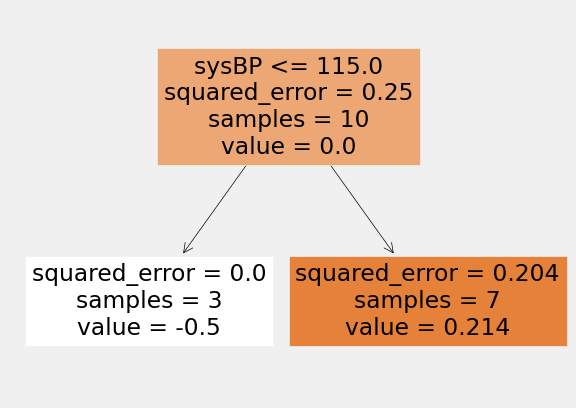

In [23]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=1)
regressor.fit(df[['Age', 'sysBP']], df['res_0']) # Note: 'res_0'
                                            # is outcome column

tree.plot_tree(regressor,
           feature_names = ['Age', 'sysBP'], 
           filled = True);


#### k=1: 

Once the small tree is built (here - a stump, which is smaller than usual): 

* Previous residuals and previous probabilities $\rightarrow$ output for each leaf
* Outputs for leaves and learning rate $\rightarrow$ new log odds
* New log odds $\rightarrow$ new probabilities
* Outcome minus new probabilities $\rightarrow$ new residuals (for next tree)

<br/> 

Now we can **repeat** the process...




#### The output for each leaf is calculated as follows: 

$\begin{eqnarray}
Output &=&  \frac{\sum_{\text{records reaching leaf}} Residual_{k-1}}{\sum_{\text{records reaching leaf}} p_{k-1}(1-p_{k-1})} 
\end{eqnarray}$ 

<br/> 

In a nutshell:

* This expression comes from an **approximation** of a max likelihood calculation. 
    
* Under the hood, the objective of gradient boosting is to minimize a loss function (the additive inverse of the log likelihood) by adding weak learners using gradient descent. 
    
* The log likelihood function is the same as the log likelihood in logistic regression.
    
* For regression problems, the loss function will typically be the Mean squared error (MSE).    

<br/> 

<br/> 

$\begin{eqnarray}
Output_{left} &=& \frac{-1/2-1/2-1/2}{1/2(1-1/2) + 1/2(1-1/2) + 1/2(1-1/2)} \\ &=& \frac{-3/2}{3/4} = -2 \\
Output_{right} &=& {\tiny \frac{-1/2+1/2+1/2+1/2-1/2+1/2+1/2}{1/2(1-1/2) + 1/2(1-1/2) + 1/2(1-1/2) + 1/2(1-1/2) + 1/2(1-1/2) + 1/2(1-1/2) + 1/2(1-1/2)}} \\ 
&=& \frac{3/2}{7/4} = \frac 67
\end{eqnarray}$ 

<br>


#### The new **log odds** for each record is $$ log\_odds_0 + Learning\_Rate \times \sum_{j=1}^{current}  Tree_j\_output  $$


* First record reaches left leaf (and true outcome is $0$) <br/> 
    $\begin{eqnarray}
    \rightarrow && \log\left[odds\right] = 0 + 0.2 \times -2 = -0.4 \\
    \rightarrow && p_1 = \frac 1{1+e^{-\log\left[odds\right]}} = \frac 1{1+e^{0.4}} \simeq 0.401 \\
    \rightarrow && residual_1 = -0.401
    \end{eqnarray}$


<br/> 

<br/> 

* Second record reaches right leaf (and true outcome is $0$) <br/> 
    $\begin{eqnarray}
    \rightarrow && \log\left[odds\right] = 0 + 0.2 \times \frac 67 = 0.171 \\
    \rightarrow && p_1 = \frac 1{1+e^{-\log\left[odds\right]}} = \frac 1{1+e^{-0.171}} \simeq 0.543 \\
    \rightarrow && residual_1 = -0.543
    \end{eqnarray}$

<br/> 

<br/> 

* Third record reaches right leaf (and true outcome is $1$) <br/> 
    $\begin{eqnarray}
    \rightarrow && \log\left[odds\right] = 0 + 0.2 \times \frac 67 = 0.171 \\
    \rightarrow && p_1 = \frac 1{1+e^{-\log\left[odds\right]}} = \frac 1{1+e^{-0.171}} \simeq 0.543 \\
    \rightarrow && residual_1 = 0.457
    \end{eqnarray}$



<br/> 

See also [here](https://blog.paperspace.com/gradient-boosting-for-classification/).

    




In [24]:
df['left_1'] = df.sysBP < 115

output_left = df.loc[df.left_1, 'res_0'].sum()
tmp = df.loc[df.left_1, 'p_hat_0']
tmp = (tmp*(1- df.loc[df.left_1, 'p_hat_0']))
output_left = output_left / tmp.sum()
df.loc[df.left_1, 'output_1'] = output_left

output_right = df.loc[~df.left_1, 'res_0'].sum()
tmp = df.loc[~df.left_1, 'p_hat_0']
tmp = tmp * ((1- df.loc[~df.left_1, 'p_hat_0']))
output_right = output_right / tmp.sum()
df.loc[~df.left_1, 'output_1'] = output_right

df['logodds_1'] =  df['logodds_0'] + lr * df['output_1']        

df['p_hat_1'] = 1 / (1 + np.exp(-1*df.logodds_1))

df['res_1'] = df.HD - df.p_hat_1
df

,Age,sysBP,HD,logodds_0,p_hat_0,res_0,left_1,output_1,logodds_1,p_hat_1,res_1
0,20,100,0,0.0,0.5,-0.5,True,-2.000000,-0.400000,0.401312,-0.401312
1,30,130,0,0.0,0.5,-0.5,False,0.857143,0.171429,0.542752,-0.542752
2,40,150,1,0.0,0.5,0.5,False,0.857143,0.171429,0.542752,0.457248
3,45,140,1,0.0,0.5,0.5,False,0.857143,0.171429,0.542752,0.457248
4,50,110,0,0.0,0.5,-0.5,True,-2.000000,-0.400000,0.401312,-0.401312
5,60,140,1,0.0,0.5,0.5,False,0.857143,0.171429,0.542752,0.457248
6,65,120,0,0.0,0.5,-0.5,False,0.857143,0.171429,0.542752,-0.542752
7,70,110,0,0.0,0.5,-0.5,True,-2.000000,-0.400000,0.401312,-0.401312
8,80,130,1,0.0,0.5,0.5,False,0.857143,0.171429,0.542752,0.457248
9,90,120,1,0.0,0.5,0.5,False,0.857143,0.171429,0.542752,0.457248


### Note the improvement: 

Only two predictions will be wrong now:

* Second record (index=1): $HD=0$ but $\hat p_1 > 0.5$ 
* Seventh record (index=6): $HD=0$ but $\hat p_1 > 0.5$



### From here on out, each consecutive tree will use the previous RESIDUALS as the outcome for building the tree! 



#### In preparation for k=2: build the second tree the way that regression trees are built (similar to classification trees) with previous residuals as 'outcomes': 



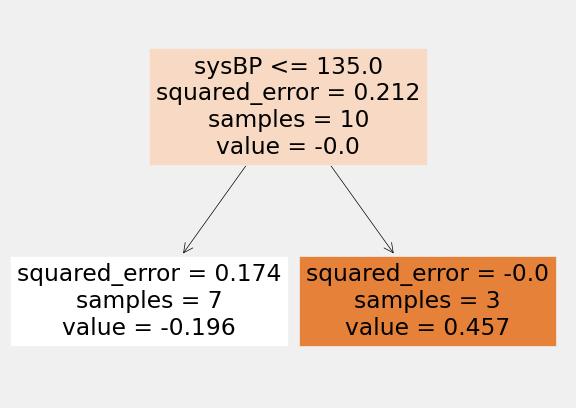

In [25]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=1)
regressor.fit(df[['Age', 'sysBP']], df['res_1']) # Note 'res_1' 
                                            # is outcome column

tree.plot_tree(regressor,
           feature_names = ['Age', 'sysBP'], 
           filled = True);



#### Calculate the new log odds and new probabilities as before: 

* Previous residuals and previous probabilities $\rightarrow$ output for each leaf
* Outputs for leaves of previous trees and learning rate $\rightarrow$ new log odds
* New log odds $\rightarrow$ new probabilities
* Outcome minus new probabilities $\rightarrow$ new residuals (for next tree)



In [26]:
df['left_2'] = df.sysBP < 135

output_left = df.loc[df.left_2, 'res_1'].sum()
tmp = df.loc[df.left_2, 'p_hat_1']
tmp = (tmp*(1- df.loc[df.left_2, 'p_hat_1']))
output_left = output_left / tmp.sum()
df.loc[df.left_2, 'output_2'] = output_left

output_right = df.loc[~df.left_2, 'res_1'].sum()
tmp = df.loc[~df.left_2, 'p_hat_1']
tmp = tmp * ((1- df.loc[~df.left_2, 'p_hat_1']))
output_right = output_right / tmp.sum()
df.loc[~df.left_2, 'output_2'] = output_right
        
df['logodds_2'] = df['logodds_0']+lr * df['output_1']\
                                 +lr * df['output_2']  

df['p_hat_2'] = 1 / (1 + np.exp(-1*df.logodds_2))

df['res_2'] = df.HD - df.p_hat_2

# Drop columns for display purposes: 
df2 = df.drop(['logodds_0', 'res_0'], axis=1)
df2 = df2.drop(['logodds_1', 'res_1', 'left_1', 'output_1'],axis=1)
df2 = df2.drop(['logodds_2', 'res_2', 'left_2', 'output_2'],axis=1)
df2


,Age,sysBP,HD,p_hat_0,p_hat_1,p_hat_2
0,20,100,0,0.5,0.401312,0.363435
1,30,130,0,0.5,0.542752,0.502735
2,40,150,1,0.5,0.542752,0.631794
3,45,140,1,0.5,0.542752,0.631794
4,50,110,0,0.5,0.401312,0.363435
5,60,140,1,0.5,0.542752,0.631794
6,65,120,0,0.5,0.542752,0.502735
7,70,110,0,0.5,0.401312,0.363435
8,80,130,1,0.5,0.542752,0.502735
9,90,120,1,0.5,0.542752,0.502735


#### Probabilities for the second and seventh moved in the right direction 

* And probabilities for records $1,3,4,5,6$ and $8$ moved away from the $0.5$ treshold. 

* But errors for the ninth and tenth records moved in the wrong direction. 

<br/> 

With this 'dataset' the algorithm may not do better than two errors. In any case, we'll stop 'running' it. 

### Making a prediction of log odds based on new data $x_{\text{new}}$ 

This would require using the trees created during training:

* Run the new data ($x_{\text{new}}$) through the all of the trees built using the training data.
* Sum the outputs from the leaves it ends up in. 
* Multiply the sum by the learning rate.
* Add the result to $\text{logodds}^{(0)}$ (from training) to get the new prediction. 

<br> 


## Implementing Gradient Boosting for clasification with `sklearn`

In [27]:
print(predictors)
brexit_df.head()

['degree', 'PopMixedConst%', 'PopWhiteReg%']


,Constituency,Leave,Remain,Brexit,PCON14CD,house,salary,publicsector,degree,age,...,PopMixedUKNum,PopAsianUKNum,PopBlackUKNum,PopOtherUKNum,PopTotalUK%,PopWhiteUK%,PopMixedUK%,PopAsianUK%,PopBlackUK%,PopOtherUK%
0,Aberavon,60.12%,39.88%(est.),1,W07000049,95000,490.3,25.2,16.6,39.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
1,Aberconwy,52.20%,47.8%(est.),1,W07000058,155000,496.3,23.4,27.1,39.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
2,Aberdeen North,43.09%,56.91%(est.),0,S14000001,x,538.3,37.0,29.0,41.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
3,Aberdeen South,32.14%,67.86%(est.),0,S14000002,x,584.1,9.2,40.3,40.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186
4,Airdrie and Shotts,39.84%,60.16%(est.),0,S14000003,x,482.3,26.2,15.5,46.0,...,1250229,4373339,1904684,580374,1,0.871663,0.019788,0.069218,0.030146,0.009186


F1 score for the *training* dataset = 1.000
F1 score for the *testing* dataset = 0.907


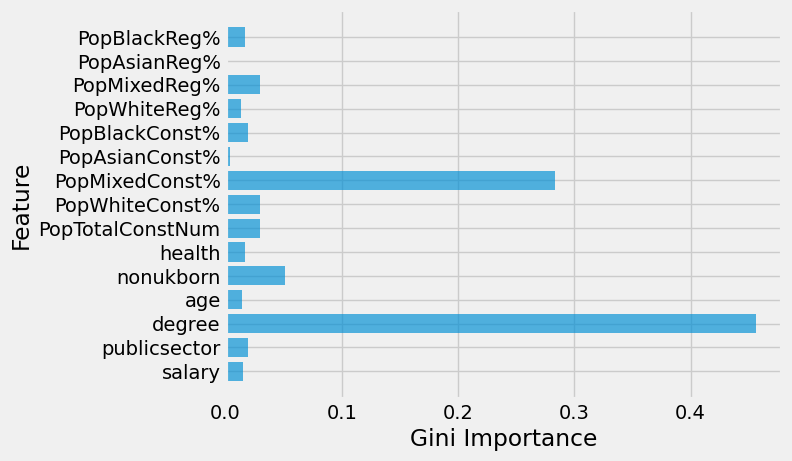

In [23]:
from sklearn.model_selection import train_test_split

###############################################
# Split data to training and testing datasets #
###############################################
X_train, X_test, y_train, y_test = \
    train_test_split(brexit_df[predictors], 
                     brexit_df[outcome], 
                     test_size=0.3) 

from sklearn.ensemble import GradientBoostingClassifier \
                          as grad_boost
from sklearn.metrics import mean_squared_error, roc_curve, \
                            auc, f1_score    

#############################################
# Cross validate to get evaluation metrics  #
#############################################

model = grad_boost(n_estimators=150)  


##########################################
# Train the model / fit model parameters #
#       and test on testing dataset      #
##########################################

model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_hat = model.predict(X_test)
print('F1 score for the *training* dataset = %.3f'%\
      f1_score(y_train, y_train_hat))
print('F1 score for the *testing* dataset = %.3f'%\
      f1_score(y_test, y_hat))

plt.barh(predictors, model.feature_importances_, alpha=0.67);
plt.xlabel("Gini Importance")
plt.ylabel("Feature");



#### Note (I)

Parameter tuning can be done with `GridSearchCV`, `RandomizedSearchCV`, and `feature_importances_` as shown above. 


#### Note (II) 

[**XGBoost (Extreme Gradient Boosting)**](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)
is an optimized implementation of gradient boosting that includes additional regularization and speed enhancements. After installing the model, `import xgboost as xgb` etc.  

## Why does gradient boosting work (some theory)? 

### Useful reminders / calculations

* For convenience that hats denoting *predicted* will be removed:
$$ \hat p \equiv p \ \ \ , \ \ \ \widehat{\text{logodds}} \equiv \text{logodds} $$ while $y_i$ will denote *observed* outcomes. 

<br> 

* Log odds and probabilities: 
$$\begin{eqnarray}
&& \text{logodds} = \log \frac{p}{1-p} \\
\rightarrow && p = \frac{e^{\text{logodds}}}{1+e^{\text{logodds}}} \ \ \ , \ \ \ 
1-p = \frac{1}{1+e^{\text{logodds}}}
\end{eqnarray}$$ 

<br> 

* The cross entropy loss function (in terms of probabilities or log odds): 
$$\begin{eqnarray}
{\cal L} &=& -\sum \left[ y_i \log p_i + \left(1-y_i\right) \log \left(1-p_i\right) \right] \\
&=& -\sum \left[ y_i \text{logodds}_i - y_i \log\left(1+e^{\text{logodds}_i} \right) - \left(1-y_i\right)  \log\left(1+e^{\text{logodds}_i} \right) \right] \\
&=& \sum \left[\log\left(1+e^{\text{logodds}_i} \right) - y_i \text{logodds}_i \right] 
\end{eqnarray}$$ 


$$\begin{eqnarray}
\rightarrow \frac{\partial {\cal L}}{\partial \text{logodds}_i} &=& \frac{e^{\text{logodds}_i}}{1+e^{\text{logodds}_i}} - y_i = p_i - y_i = -\text{residual}_i \\ 
\frac{\partial^2 {\cal L}}{\partial \text{logodds}_i^2} &=& \frac{\left( 1+e^{\text{logodds}_i} \right)e^{\text{logodds}_i}-e^{\text{logodds}_i} e^{\text{logodds}_i} }{\left( 1+e^{\text{logodds}_i} \right)^2} \\
&& = \frac{e^{\text{logodds}_i}}{1+e^{\text{logodds}_i}} \frac{1}{1+e^{\text{logodds}_i}} = p_i(1-p_i) 
\end{eqnarray}$$ 



### The gradient boosting algorithm 

Given the observed data $\left\{ x_i, y_i \right\}$ and the loss function ${\cal L} = {\cal L}\left(y_i, \widehat{\text{logodds}}  \right)$:

1. Set an initial guess of the predicted log odds: $$\text{logodds}_0 = \log{\frac{1/2}{1-1/2}} = 0$$  

2. For t in range(1,n_estimators+1): # build a tree for each $m$ 
    * Calculate the residuals at step $t$: $$\text{residual}_i^{(t)} = y_i - p_i^{(t-1)} = \left. -\frac{\partial {\cal L}}{\partial \text{logodds}_i}\right|_{\text{logodds}_i^{(t-1)}}$$ 
    * Fit a *regression tree* to predict the residuals.  
    * Calculate the output$_j$ for each leaf ($j$) in the tree $(t)$. <br> The output should be a the value that would **minimize the loss function (for the records reaching leaf $j$) when added to the previous log odds**:   
    $$\begin{eqnarray}
     \text{tree}^{(t)}\hspace{-3mm}\text{_output}_j &=& \underset{\omega}{\operatorname{argmin}} \left[ \underset{i \in \text{leaf $j$}}{\operatorname{{\cal L}}} \left(\{y_i\}, \{\text{logodds}_i^{(t-1)}+ \omega\} \right) \right] 
    \end{eqnarray}$$

#### Minimizing the cross-entropy loss function is complicated; <br> easier to minimize a (Taylor) approximation

Minimizing $$ {\cal L}_i  = \log\left[ e^{\left(\text{logodds}_i^{(t-1)} + \omega \right)} -y_i \left(\text{logodds}_i^{(t-1)} + \omega \right)   \right] $$
with respect to $\omega$ is time consuming. 

<br> 

Instead, ${\cal L}_i$ is approximated using a Taylor series:  

$$\begin{eqnarray}
&& {\cal L}_i \simeq {\cal L}\left(y_i, \text{logodds}_i^{(t-1)} \right) + \frac{\partial {\cal L}_i }{\partial \omega} \ \omega + \frac 12 \frac{\partial^2 {\cal L}_i }{\partial \omega^2} \ \omega^2 \\ 
&& = \text{Constant} + \left( p_i - y_i \right) \omega + \frac 12 \left[ p_i(1-p_i) \right] \omega^2 \\ 
&& \\ 
&& \frac{\partial {\cal L}_i }{\partial \omega} = 0 \\
\rightarrow && \omega^* = \frac{2(y_i-p_i)}{p_i(1-p_i)} \sim \frac{y_i-p_i}{p_i(1-p_i)} 
\end{eqnarray}$$

A term like this is contributed by every record that reaches leaf $j$ <br> (the factor of $2$ can be absorbed by the learning rate - see below). 

2. (continued)
    * Therefore, the output that **minimizes the loss function for the records reaching leaf $j$ (in tree $t$)** is: 
    $$\begin{eqnarray}
    && \\ 
     \text{tree}^{(t)}\hspace{-3mm}\text{_output}_{\text{leaf $j$}} &=& \underset{\omega}{\operatorname{argmin}} \left[ \underset{i \in \text{leaf $j$}}{\operatorname{{\cal L}}} \left(\{y_i\}, \{\text{logodds}_i^{(t-1)}+ \omega\} \right) \right] \\ 
     && \\ 
    &\simeq& \sum_{i \in \text{leaf $j$}} \frac{\text{residual}_i^{(t-1)}}{p_i^{(t-1)}(1-p_i^{(t-1)})} \\
    && \\ 
    \end{eqnarray}$$
    
    *  Make a new **prediction of the log odds**: $$\begin{eqnarray}
    && \\ 
&& \text{logodds}_i^{(t)} = \text{logodds}_i^{(t-1)} + \text{learning_rate} \times \text{tree}^{(t)}\hspace{-3mm}\text{_output}_{\underset{\large \text{sample $i$ appears}}{\operatorname{\text{leaf $j$ where}}}} \\
&& \ \ \  \text{ where } \ \  0 < \text{learning_rate} < 1 \\
&& 
\end{eqnarray}$$
    
<br> 

Note that the recursive equation at the end of step $2$ implies that when the loop is over: 

$$ \text{logodds}_i^{(t_{\text{final}})} = \text{logodds}_i^{(0)} + \text{learning_rate} \times \sum_{t=1}^{t_{\text{final}}-1} \text{tree}^{(t)}\hspace{-3mm}\text{_output}_{\underset{\large \text{sample $i$ appears}}{\operatorname{\text{leaf $j$ where}}}} $$ 

<br> 
<br> 
<br> 

3. To make a new log odds prediction: 
    * Run the new data ($x_{\text{new}}$) through the all of the trees built using the training data.
    * Sum the outputs from the leaves it ends up in. 
    * Multiply the sum by the learning rate.
    * Add the result to $\text{logodds}^{(0)}$ (from training) to get the new prediction. 

#### Why use a learning rate that is smaller than $1$? 

The learning rate is perhaps the most important hyperparameter of gradient boosting. 

* Reduce Overfitting: gradually updating the predictions in smaller steps enables exploring the solution space more thoroughly and  preventing large/sudden changes that may lead to overfitting.

* Stabilizing the training process: avoiding overshooting and oscillations (similar reasons). 

* A small learning rate reduces the effect that each tree has on the final prediction. Typically, this will mean slower conversion toward a potentially more accurate prediction (stable convergence, better generalizability).  



### So why does it work? 

The key intuition is that each iterative step corrects the predicted log odds **in the direction opposite of the gradient** of the loss function. 

Adding another weak learner to a Gradient Boosting model adds a term $\sim$ the negative of the gradient of the loss function to obtain the next approximation:

$$\begin{align}
& \text{Gradient Descent:} & 
& \hspace{-6mm} \beta_t  = &
& \hspace{-6mm} \beta_{t-1} &
& \hspace{-9mm} - \eta \ \ \nabla f \left( \beta_{t-1} \right) & \\
& \text{Gradient Boosting:} & 
& \hspace{-6mm}  \text{logodds}_i^{(t)} = &
& \hspace{-6mm} \text{logodds}_i^{(t-1)} &
& \hspace{-9mm} +  \eta \ \  \text{tree}^{(t)}\hspace{-3mm}\text{_output}_{\underset{\large \text{sample $i$ appears}}{\operatorname{\text{leaf $j$ where}}}} &
\end{align}$$ 

---

Where the 'tree outputs' move the predictions in the **direction that minimizes the loss function**, either approximately or exactly.

---


(Analogous to $-\nabla f$ moving $\beta$ in the direction that minimizes the loss function). 

<br> 



## Gradient Boosting for Regression (in a nutshell) 

* Sequentially generate small trees (typically, $8$-$32$ leaves).
* The loss function is proportional to the sum of squares (instead of cross entropy). 
* **Residuals** from each tree inform the next tree. 
* Leaf outputs are scaled by the `learning rate` and summed. 


### Gradient boosting for regression - theory in a nutshell 

The calculations are simpler since 

$$\begin{eqnarray} 
&& {\cal L} = \underbrace{\frac 12}_{\text{for convenience}} \sum \left[y_i - \left(\hat y_i + \omega \right)\right]^2  \\
\rightarrow && \frac{\partial {\cal L}_i}{\partial \omega} =  - \left(y_i - \hat y_i - \omega \right) = \text{residual}_i - \omega
\end{eqnarray}$$

There is no need to approximate the loss function: 
* The minimizing value for each record $i$ will be the corresponding residual.
* The minimizing value for all the records that reach leaf $j$ will be the average residual (each record reaching leaf $j$ will contribute its residual and one '$\omega$' to the sum that will be equated to zero). 

<br> 

* More examples can be found in many places, including [here](https://towardsdatascience.com/all-you-need-to-know-about-gradient-boosting-algorithm-part-1-regression-2520a34a502), [here](https://towardsdatascience.com/all-you-need-to-know-about-gradient-boosting-algorithm-part-2-classification-d3ed8f56541e), and [here](https://explained.ai/gradient-boosting/descent.html). 

* The original paper can be found [here](https://projecteuclid.org/journals/annals-of-statistics/volume-29/issue-5/Greedy-function-approximation-A-gradient-boosting-machine/10.1214/aos/1013203451.full). 
